# MASS MANMOGRAPHIC SEGMENTATION

In [1]:
# loading the Libraries 
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.optimizers import Adam

### Defining the Function for loading and preprocess the data 

In [2]:
# Function to load the dataset
def load_dataset(base_path, class_index, image_size):
    images = []
    masks = []
    filenames = []
    for category in class_index:
        category_path = os.path.join(base_path, category)
        if not os.path.exists(category_path):
            raise FileNotFoundError(f"The category path does not exist: {category_path}")
        
        for file in os.listdir(category_path):
            if 'mask' not in file:  # Exclude mask files for image loading
                image_path = os.path.join(category_path, file)
                mask_path = os.path.join(category_path, file.split('.')[0] + '_mask.png')
                
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                
                if image is not None and mask is not None:
                    if image.shape == mask.shape:
                        image_resized = cv2.resize(image, (image_size, image_size))
                        mask_resized = cv2.resize(mask, (image_size, image_size))
                        images.append(image_resized)
                        masks.append(mask_resized)
                        filenames.append(file)
                    else:
                        print(f"Warning: Image and mask shape mismatch for {file}")
                else:
                    print(f"Warning: Could not load image or mask for {file}")

    return np.array(images), np.array(masks), filenames

In [3]:
# Function to preprocess the images
def preprocess_images(images, masks):
    images = images.astype('float32') / 255.0
    masks = masks.astype('float32') / 255.0
    masks = np.expand_dims(masks, axis=-1)
    return np.expand_dims(images, axis=-1), masks

### Seting up the model architecture 

In [4]:
# U-Net Model Architecture
def unet_model(input_size):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs, conv10)

    return model

### Loading the dataset, setting the parameter, splitting and data augmentation 

In [10]:
# Set the base path to the dataset
BASE_PATH = "C:/Users/HP/OneDrive/Desktop/Karatu/Breast_Cancer/Breast_Cancer_Segmentation/Dataset_BUSI_with_GT" # change the path to yours
unique_classes = []

# Check if the path exists and list unique classes
if os.path.exists(BASE_PATH):
    for path in os.listdir(BASE_PATH):
        unique_classes.append(path)
    print("Unique classes found:", unique_classes)
else:
    raise FileNotFoundError(f"The specified path does not exist: {BASE_PATH}")

# Sort classes to ensure consistent order
class_index = sorted(unique_classes)
print("Class index sorted:", class_index)


Unique classes found: ['benign', 'malignant', 'normal']
Class index sorted: ['benign', 'malignant', 'normal']


In [11]:
# setting the Parameters
image_size = 256
images, masks, filenames = load_dataset(BASE_PATH, class_index, image_size)
images, masks = preprocess_images(images, masks)


In [12]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)


In [13]:
# Data augmentation
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

In [14]:
# Provide the same seed and keyword arguments to the flow methods
seed = 1
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

In [15]:
image_generator = image_datagen.flow(X_train, batch_size=16, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=16, seed=seed)

In [16]:
# Combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

#### Compile and train the U-Net model

In [ ]:
 """THIS code was executed USING AWS EC2 Instance GPU, for speed)
     feel free to retrain the model if you have a high (GPU) processor """
# # Compile and train the U-Net model
# input_size = (image_size, image_size, 1)
# model = unet_model(input_size)
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# history = model.fit(train_generator, steps_per_epoch=len(X_train) // 16, epochs=50, validation_data=(X_test, y_test))

"""Save the model (although the model has been trained and saved using AWS EC2 GPU, it is too large to send to gitHUB"""
# model.save('unet_model.h5') # save the maodel should in case it is trained again

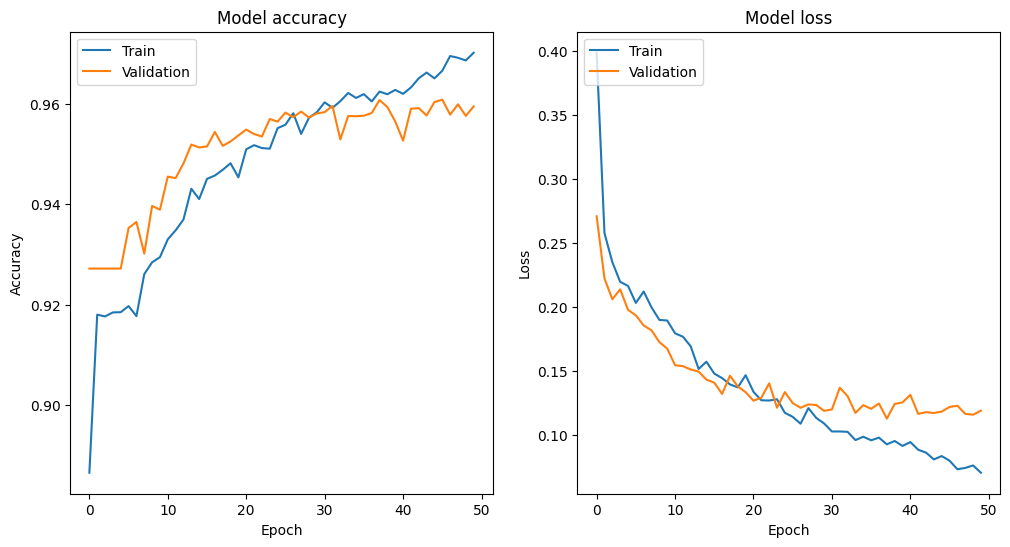

In [15]:
# Plot training & validation accuracy and loss values (the Validation is also the test)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

#### Code to load the trained model

In [18]:
""" this unet model has been trained using GPU AWS
Beacuse of the large size the saved model could not be pushed to github
thus, the model was downloaded 

this is the code to load the model should in case """

from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('unet_model.h5') # ensure the saved model is in the same folder as the notebook 

## Evaluation

In [14]:
# Evaluate the model on the test set (this is the model evaluation, when trained using ASW EC2 GPU)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

5/5 [==============================] - 1s 131ms/step - loss: 0.1193 - accuracy: 0.9594
Test Accuracy: 95.94%
Test Loss: 0.1193


## Prediction and Visualization of Result

In [16]:
# Visualize some predictions
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = np.random.randint(0, len(X))

    has_mask = y[ix].max() > 0  # Check if any mask is present in the ground truth

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix].squeeze(), cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[0].set_title('Original')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('Ground Truth')

    ax[2].imshow(preds[ix].squeeze(), cmap='gray')
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[2].set_title('Prediction')

    ax[3].imshow(binary_preds[ix].squeeze(), cmap='gray')
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[3].set_title('Binary Prediction')

    plt.show()

2/5 [===========>..................] - ETA: 0s

5/5 [==============================] - 1s 128ms/step


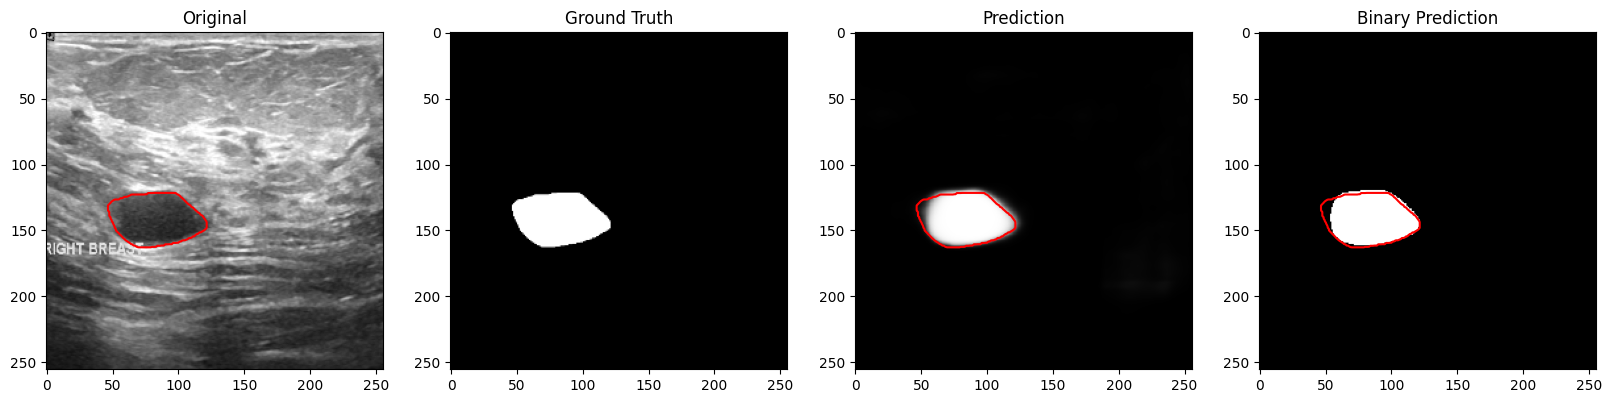

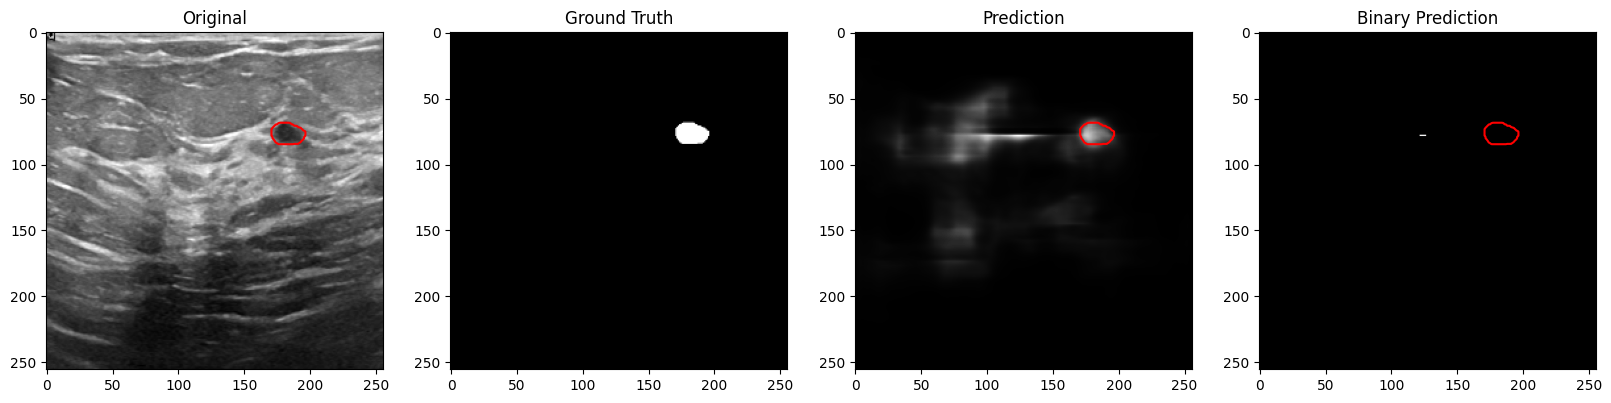

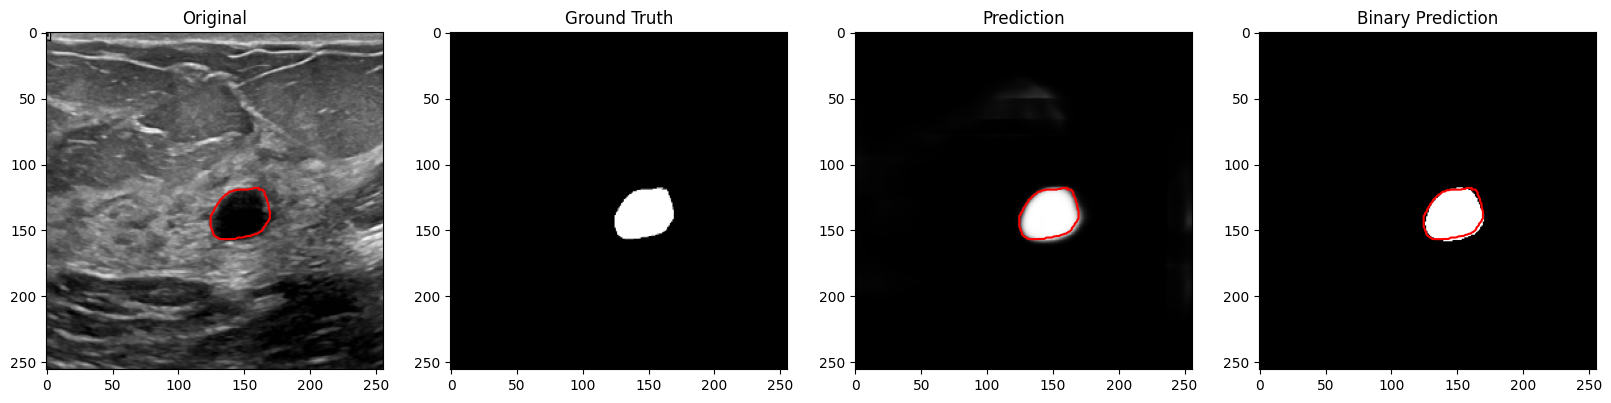

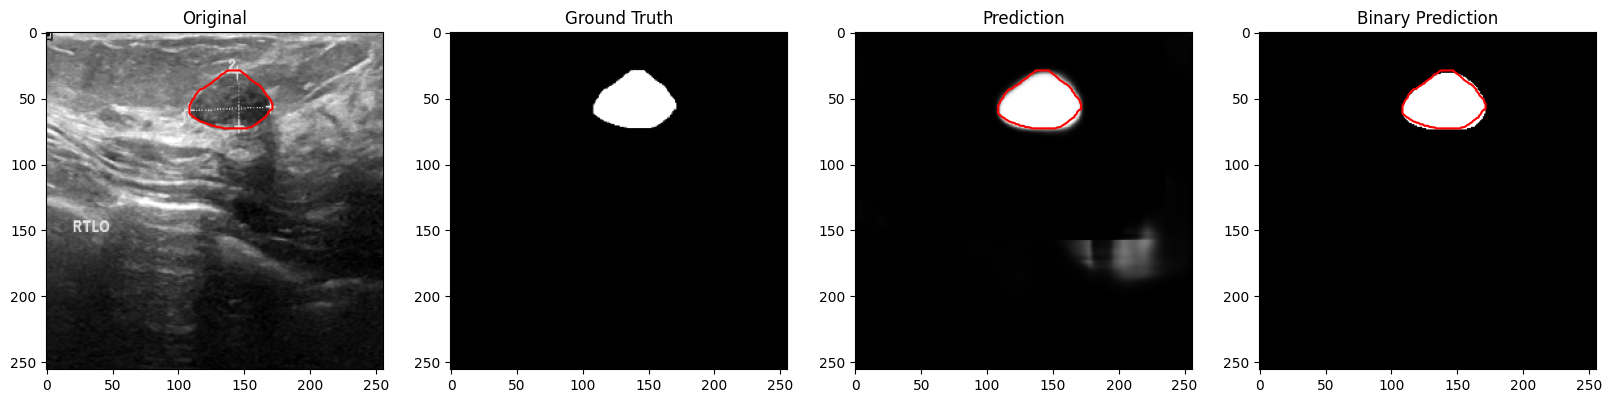

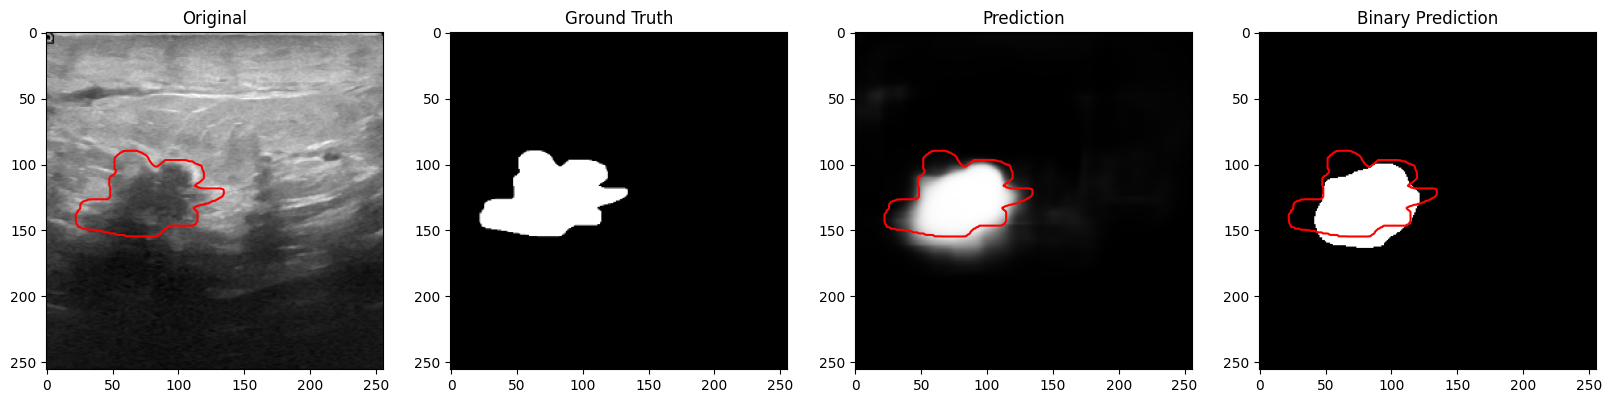

In [17]:
# Predict on the validation set and visualize results
preds_val = model.predict(X_test, verbose=1)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Plot some examples
for i in range(5): # you can adjust the range number to assess the more result 
    plot_sample(X_test, y_test, preds_val, preds_val_t)

- *Original:* This subplot shows the original input image (X).
- *Ground Truth:* This subplot shows the actual mask (y) which is the ground truth or the true segmentation mask.
- *Prediction:* This subplot shows the raw model output (preds), which contains continuous values between 0 and 1.
- *Binary Prediction:* This subplot shows the binary mask (binary_preds) which results from applying a threshold (e.g., 0.5) to the raw model output.